## CAPSTONE

# Data analysis road map


1. Load in the data
2. Clean data
    - Check for nulls
    - Unpack any
3. Preprocessing
4. EDA

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tqdm as tqdm


Since the dataset contains 8.9 million rows of data and is 5.2 gbs, the data will first be loaded in and preprocessed to a condensed size in order to be able to do an EDA on the whole dataset

Load in the dataset

In [2]:
review_data = []
with open('Movies_and_TV.json','r') as metafile:
    for x in range(2000000):
        review_data.append(json.loads(next(metafile)))

Create the dataframe and explore the data

In [3]:
review_df = pd.DataFrame(review_data)

In [4]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         2000000 non-null  float64
 1   verified        2000000 non-null  bool   
 2   reviewTime      2000000 non-null  object 
 3   reviewerID      2000000 non-null  object 
 4   asin            2000000 non-null  object 
 5   style           1869058 non-null  object 
 6   reviewerName    1999947 non-null  object 
 7   reviewText      1998502 non-null  object 
 8   summary         1999606 non-null  object 
 9   unixReviewTime  2000000 non-null  int64  
 10  vote            413317 non-null   object 
 11  image           2912 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 169.8+ MB


There are 12 columns of data and some datatypes can be changed to take up less space when storing the data

In [5]:
review_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"03 11, 2013",A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},jacki,really happy they got evangelised .. spoiler a...,great,1362960000,NaN,NaN
1,5.0,True,"02 18, 2013",A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Ken P,Having lived in West New Guinea (Papua) during...,Realistic and Accurate,1361145600,3,NaN
2,5.0,False,"01 17, 2013",A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Reina Berumen,Excellent look into contextualizing the Gospel...,Peace Child,1358380800,NaN,NaN
3,5.0,True,"01 10, 2013",A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},N Coyle,"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,1357776000,NaN,NaN
4,4.0,True,"12 26, 2012",A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},Jodie Vesely,This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,1356480000,NaN,NaN


Looking at the columns, `reviewTime` and `unixReviewTime` display the same information so `reviewTime` will be dropped. (The numeric column is kept so that it can be used for regression models in the future.) The `reviewerName` does not provide any useful information since there is a unique `reviewerID` for each reviewer. Two reviewers can have the same name but may not be the same person. Thus `reviewerName` will be dropped. The `image` column can be dropped because this project will not deal with image data. 

Before the reviewername is dropped, it will be compared with the reviewerID column to ensure they contain the same information

In [6]:
review_df['reviewerID'].value_counts()

A16CZRQL23NOIW    978
A2NJO6YE954DBH    920
ANCOMAI0I7LVG     876
A3LZGLA88K0LA0    745
A1GGOC9PVDXW7Z    745
                 ... 
AB8BM07ZTG236       1
A3LF00CD1WHAKO      1
AK8Q0975RJA77       1
AFLNF5IDDBUJ1       1
A32XZIH7HR8VJI      1
Name: reviewerID, Length: 1184787, dtype: int64

In [7]:
review_df['reviewerName'].value_counts()

Amazon Customer                          116732
Kindle Customer                            9982
Mike                                       1880
John                                       1879
Chris                                      1632
                                          ...  
Bree Long                                     1
Harvey Harte                                  1
Phillip J Montejano                           1
Lillian F Stephens                            1
Unsatisfied Customer on this product.         1
Name: reviewerName, Length: 821904, dtype: int64

The `reviewerID` and `reviewerName` column show differrent lengths. The `reviewerName` column contains less information than the `reviewerID` column because users can have the same names but reviewerID is unique. Thus reviewerID should be used.

In [8]:
# Drop the unnecessary columns
review_df.drop(columns = ['reviewTime','reviewerName','image'],inplace = True)
review_df

,overall,verified,reviewerID,asin,style,reviewText,summary,unixReviewTime,vote
0,5.0,True,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,1362960000,NaN
1,5.0,True,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,1361145600,3
2,5.0,False,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,1358380800,NaN
3,5.0,True,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,1357776000,NaN
4,4.0,True,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,1356480000,NaN
...,...,...,...,...,...,...,...,...,...
1999995,5.0,True,A1UM0LZVGQ4RYX,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it want to see more,Five Stars,1440979200,NaN
1999996,5.0,True,A3MWE7P29CDR5L,B0001GF2F6,{'Format:': ' Amazon Video'},Loved it wish it was more than two seasons.,Five Stars,1440979200,NaN
1999997,5.0,True,A3J6N3SOCENIPB,B0001GF2F6,{'Format:': ' Amazon Video'},Such a witty show with good acting. This show ...,Dark humor with lessons about life.,1440892800,NaN
1999998,4.0,True,A5O06SYSW6V93,B0001GF2F6,{'Format:': ' Amazon Video'},It's a weird (comical) look at Grim Reapers.,Four Stars,1440806400,NaN


In [9]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewerID      object 
 3   asin            object 
 4   style           object 
 5   reviewText      object 
 6   summary         object 
 7   unixReviewTime  int64  
 8   vote            object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 124.0+ MB


### Check the datatype in the column `overall`

In [10]:
review_df['overall'].value_counts()

5.0    1304630
4.0     340073
3.0     151321
1.0     123501
2.0      80475
Name: overall, dtype: int64

It looks like the values for the overall column are contained between 1 and 5 which makes sense since its a review out of 5. All of these are also integers so the datatype can be changed to a int8 type

In [11]:
review_df['overall'] = review_df['overall'].astype('int8')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int8  
 1   verified        bool  
 2   reviewerID      object
 3   asin            object
 4   style           object
 5   reviewText      object
 6   summary         object
 7   unixReviewTime  int64 
 8   vote            object
dtypes: bool(1), int64(1), int8(1), object(6)
memory usage: 110.6+ MB


### Check the datatype in the column `Vote`

For the `vote` column, since the NaN values are essentially no votes with can be represented with 0, the NaN values will be replaced with a zero. There are also commas within the vote that causes problems when converted to an int so they will be removed.

In [12]:
review_df['vote'] = review_df['vote'].str.replace(r"\,","",regex = True)
review_df['vote'] = review_df['vote'].fillna(0)
review_df.head()

,overall,verified,reviewerID,asin,style,reviewText,summary,unixReviewTime,vote
0,5,True,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},really happy they got evangelised .. spoiler a...,great,1362960000,0
1,5,True,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},Having lived in West New Guinea (Papua) during...,Realistic and Accurate,1361145600,3
2,5,False,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},Excellent look into contextualizing the Gospel...,Peace Child,1358380800,0
3,5,True,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,1357776000,0
4,4,True,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,1356480000,0


The votes have now all been converted to numbers and the datatype can now be changed.

In [13]:
review_df['vote'] = review_df['vote'].astype('int32')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int8  
 1   verified        bool  
 2   reviewerID      object
 3   asin            object
 4   style           object
 5   reviewText      object
 6   summary         object
 7   unixReviewTime  int64 
 8   vote            int32 
dtypes: bool(1), int32(1), int64(1), int8(1), object(5)
memory usage: 103.0+ MB


### Check the datatype in the column `unixReviewTime`

The univReviewTime column can be converted to an int32 for the current project because the maximum int32 value will be reached in January, 2038 which has not occured yet. Thus the data is bound by int32 values.

In [14]:
review_df['unixReviewTime'] = review_df['unixReviewTime'].astype('int32')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int8  
 1   verified        bool  
 2   reviewerID      object
 3   asin            object
 4   style           object
 5   reviewText      object
 6   summary         object
 7   unixReviewTime  int32 
 8   vote            int32 
dtypes: bool(1), int32(2), int8(1), object(5)
memory usage: 95.4+ MB


### Remove text data from the dataframe

Text data will be removed from the dataset for the initial analysis of the review data to try to predict the overall score given certain features of the review.

In [15]:
review_df.drop(columns = ['reviewText','summary'],inplace = True)
review_df

,overall,verified,reviewerID,asin,style,unixReviewTime,vote
0,5,True,A3478QRKQDOPQ2,0001527665,{'Format:': ' VHS Tape'},1362960000,0
1,5,True,A2VHSG6TZHU1OB,0001527665,{'Format:': ' Amazon Video'},1361145600,3
2,5,False,A23EJWOW1TLENE,0001527665,{'Format:': ' Amazon Video'},1358380800,0
3,5,True,A1KM9FNEJ8Q171,0001527665,{'Format:': ' Amazon Video'},1357776000,0
4,4,True,A38LY2SSHVHRYB,0001527665,{'Format:': ' Amazon Video'},1356480000,0
...,...,...,...,...,...,...,...
1999995,5,True,A1UM0LZVGQ4RYX,B0001GF2F6,{'Format:': ' Amazon Video'},1440979200,0
1999996,5,True,A3MWE7P29CDR5L,B0001GF2F6,{'Format:': ' Amazon Video'},1440979200,0
1999997,5,True,A3J6N3SOCENIPB,B0001GF2F6,{'Format:': ' Amazon Video'},1440892800,0
1999998,4,True,A5O06SYSW6V93,B0001GF2F6,{'Format:': ' Amazon Video'},1440806400,0


In [16]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int8  
 1   verified        bool  
 2   reviewerID      object
 3   asin            object
 4   style           object
 5   unixReviewTime  int32 
 6   vote            int32 
dtypes: bool(1), int32(2), int8(1), object(3)
memory usage: 64.8+ MB


### Check the datatype in the column `style`

The NaN values in the column `style` will be filled with 'other' since the values is unknown.
The column style will be converted to strings so that a duplicate check can be performed for the dataset. (Converting to str, then removing the key for the dictionary is more computationally effective for getting the value in the key-value pair than looping through every individual key and accessing the value. *Note: the latter was tried and took 10 mins for 1 million key-value pairs. The former took <5s.)

In [17]:
review_df['style'] = review_df['style'].fillna('Other')

In [18]:
# Change values in the style column from dict to str
review_df['style'] = review_df['style'].astype('str')

In [19]:
# Remove the keys in the key-value pair
review_df['style'] = review_df['style'].str.replace(r"{'Format:': ' ","",regex = True)
review_df['style'] = review_df['style'].str.replace(r"'}","",regex = True)

Check results

In [20]:
review_df['style']

0              VHS Tape
1          Amazon Video
2          Amazon Video
3          Amazon Video
4          Amazon Video
               ...     
1999995    Amazon Video
1999996    Amazon Video
1999997    Amazon Video
1999998    Amazon Video
1999999    Amazon Video
Name: style, Length: 2000000, dtype: object

The style column now contains the relavent data.

### Drop any duplicates in the dataframe

In [21]:
review_df.drop_duplicates(inplace = True, ignore_index = True)

In [22]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998635 entries, 0 to 1998634
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int8  
 1   verified        bool  
 2   reviewerID      object
 3   asin            object
 4   style           object
 5   unixReviewTime  int32 
 6   vote            int32 
dtypes: bool(1), int32(2), int8(1), object(3)
memory usage: 64.8+ MB


1365 entries has been dropped.

### Create a clean df that only has numeric values for the regression analysis

In [23]:
clean_df = review_df[['overall','unixReviewTime','vote']].copy()

Check the created df

In [24]:
clean_df

,overall,unixReviewTime,vote
0,5,1362960000,0
1,5,1361145600,3
2,5,1358380800,0
3,5,1357776000,0
4,4,1356480000,0
...,...,...,...
1998630,5,1440979200,0
1998631,5,1440979200,0
1998632,5,1440892800,0
1998633,4,1440806400,0


### Preprocess verified column

In [25]:
review_df['verified'].value_counts()

True     1312839
False     685796
Name: verified, dtype: int64

Since the verified column contains only true and false, the datatype can be changed to int8 for the regression analysis

In [26]:
# Map Trues to 1 and false to 0

clean_df['verified'] = review_df['verified'].astype('int8').copy()

In [27]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998635 entries, 0 to 1998634
Data columns (total 4 columns):
 #   Column          Dtype
---  ------          -----
 0   overall         int8 
 1   unixReviewTime  int32
 2   vote            int32
 3   verified        int8 
dtypes: int32(2), int8(2)
memory usage: 19.1 MB


Convert the reviewerName column to a numeric representation using `pd.factorize`

In [28]:
clean_df['reviewer_ID'] = pd.factorize(review_df['reviewerID'])[0]

In [29]:
# clean_df['reviewerName']= review_df['reviewerName']

Do the same for the product column (ASIN)

In [30]:
clean_df['itemID'] = pd.factorize(review_df['asin'])[0]

In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998635 entries, 0 to 1998634
Data columns (total 6 columns):
 #   Column          Dtype
---  ------          -----
 0   overall         int8 
 1   unixReviewTime  int32
 2   vote            int32
 3   verified        int8 
 4   reviewer_ID     int64
 5   itemID          int64
dtypes: int32(2), int64(2), int8(2)
memory usage: 49.6 MB


There are 5804 different review dates

Show correlations between different features

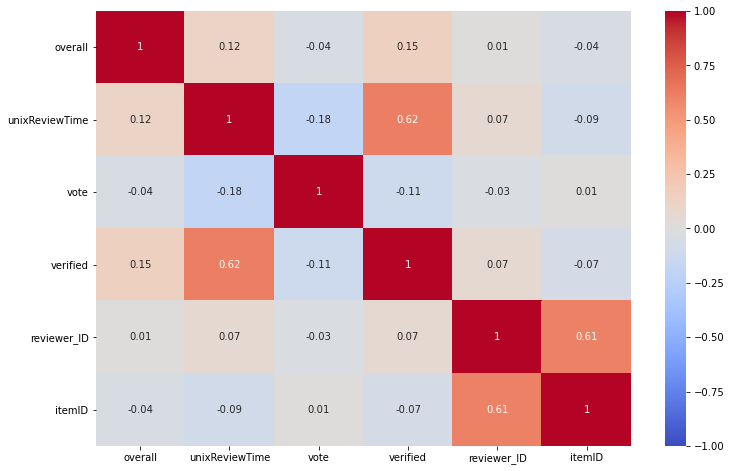

In [32]:
plt.figure(figsize= [12,8])
sns.heatmap(clean_df.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [44]:
X = clean_df.drop(columns =['vote','itemID'])
Y = clean_df['vote']

X_withconstant = sm.add_constant(X)

In [45]:
rmodel1 = sm.OLS(Y,X_withconstant)

rmodel1 = rmodel1.fit()

rmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vote   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                 1.639e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:49:29   Log-Likelihood:            -7.9024e+06
No. Observations:             1998635   AIC:                         1.580e+07
Df Residuals:                 1998630   BIC:                         1.580e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.1296      0.093    237.343      0.000      21.947      22.312
overall           -0.2540      0.008    -32.663      0.000      -0.269      -0.239
unixReviewTime -1.432e-08   7.25e-11   -197.601      0.000   -1.45e-08   -1.42e-08
verified           0.1772      0.024      7.358      0.000       0.130       0.224
reviewer_ID    -7.533e-07   2.52e-08    -29.873      0.000   -8.03e-07   -7.04e-07
================================================================================
Omnibus:                 10742073.450   Durbin-Watson:                     1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2882991892924691.000
Skew:                         278.948   Prob(JB):                           0.00
Kurtosis:                  186065.407   Cond. No.                       1.42e+10
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Check the number of unique products in the database

In [41]:
clean_df.drop(columns='item_id',inplace = True)

In [34]:
clean_df['item_id'] = review_df['asin']

**Read in the clean meta data and combine it with the clean review data**

In [35]:
meta_df = pd.read_csv('clean_meta.csv')
meta_df

FileNotFoundError: [Errno 2] No such file or directory: 'clean_meta.csv'

In [ ]:
new_df = pd.merge(clean_df, meta_df,  how='left', left_on='item_id', right_on = 'asin')

In [ ]:
new_df.head()

,overall,unixReviewTime,vote,verified,reviewer_ID,item_id,brand,rank,asin,description,category_1,category_2,category_3,category_4
0,5.0,1005177600,9,0,0,B00005N7P0,"Future US, Inc.",NaN,B00005N7P0,MAXIMUM PC is the ultimate upgrade for the sav...,Technology,Computers &amp; Internet,NaN,NaN
1,5.0,1004486400,9,0,1,B00005N7P0,"Future US, Inc.",NaN,B00005N7P0,MAXIMUM PC is the ultimate upgrade for the sav...,Technology,Computers &amp; Internet,NaN,NaN
2,3.0,1174694400,14,0,2,B00005N7OJ,Brant Publications,406,B00005N7OJ,The Magazine Antiques brings you the fascinati...,Home & Garden,Antiques & Collectibles,NaN,NaN
3,5.0,1163116800,13,0,3,B00005N7OJ,Brant Publications,406,B00005N7OJ,The Magazine Antiques brings you the fascinati...,Home & Garden,Antiques & Collectibles,NaN,NaN
4,5.0,1405296000,0,1,4,B00005N7P0,"Future US, Inc.",NaN,B00005N7P0,MAXIMUM PC is the ultimate upgrade for the sav...,Technology,Computers &amp; Internet,NaN,NaN


In [ ]:
new_df['brand'].value_counts().head(10)


Hearst Magazines                    13788
Meredith Corporation                 6941
Meredith                             4911
Conde Nast Publications              3638
National Geographic Partners LLC     3163
Trusted Media Brands, Inc            2984
Bonnier Corporation                  2774
Conde Nast                           2591
Active Interest Media                1962
American Media, Inc.                 1507
Name: brand, dtype: int64